# Waveguide Y junction

Power splitters such as Y-junctions are widely used in photonic integrated circuits across different applications. When designing a power splitter, we aim to achieve a flat broadband response, low insertion loss, and compact footprint. At the same time, the design needs to comply with the fabrication resolution and tolerance.

In this example, we demonstrate the modeling of a Y-junction for integrated photonics. The designed device shows an average insertion loss below 0.2 dB in the wavelength range of 1500 nm to 1600 nm. At the same time, it has a small footprint. The junction area is smaller than 2 $\mu m$ by 2 $\mu m$, much smaller than the typical power splitters based on multimode interference devices. The design is adapted from [Yi Zhang, Shuyu Yang, Andy Eu-Jin Lim, Guo-Qiang Lo, Christophe Galland, Tom Baehr-Jones, and Michael Hochberg, "A compact and low loss Y-junction for submicron silicon waveguide," Opt. Express 21, 1310-1316 (2013)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-21-1-1310).

<img src="img/y_junction_schematic.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import ModeSolver


[22:09:14] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=797860;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=116201;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#103\103]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.9.0rc1                                                  ]8;id=811080;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=659310;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#121\121]8;;\

## Simulation Setup  

Define simulation wavelength range to be 1.5 $\mu m$ to 1.6 $\mu m$.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range


In this model, the Y-junction is made of silicon. The top and bottom claddings are made of silicon oxide. We will model them as non-dispersive materials here.

In [3]:
n_si = 3.48  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)


The junction is discretized into 13 segments. Each segment is a tapper with the given widths. The optimum design is obtained by optimizing the 13 width parameters using the Particle Swarm Optimization algorithm. For the sake of simplicity, in this notebook, we skip the optimization procedure and only present the optimized result.

In [4]:
t = 0.22  # thickness of the silicon layer

# width of the 13 segments
w1 = 0.5
w2 = 0.5
w3 = 0.6
w4 = 0.7
w5 = 0.9
w6 = 1.26
w7 = 1.4
w8 = 1.4
w9 = 1.4
w10 = 1.4
w11 = 1.31
w12 = 1.2
w13 = 1.2

l_in = 1  # input waveguide length
l_junction = 2  # length of the junction
l_bend = 6  # horizontal length of the waveguide bend
h_bend = 2  # vertical offset of the waveguide bend
l_out = 1  # output waveguide length
inf_eff = 100  # effective infinity


First, define the junction structure by using a [PolySlab](../_autosummary/tidy3d.PolySlab.html?highlight=polyslab). The vertices are given by the widths of the segments defined above. If a smooth curve is desirable, one can interpolate the vertices to a finer grid using spline for example. 

Before proceeding further to construct other structures, we can use the [plot](../_autosummary/tidy3d.Structure.html) method to inspect the geometry. 

<AxesSubplot: title={'center': 'cross section at z=0.11'}, xlabel='x', ylabel='y'>

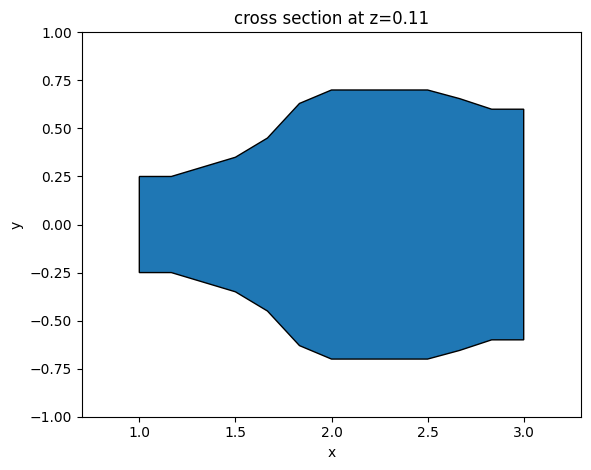

In [5]:
x = np.linspace(l_in, l_in + l_junction, 13)  # x coordinates of the top edge vertices
y = np.array(
    [w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13]
)  # y coordinates of the top edge vertices

# using concatenate to include bottom edge vertices
x = np.concatenate((x, np.flipud(x)))
y = np.concatenate((y / 2, -np.flipud(y / 2)))

# stacking x and y coordinates to form vertices pairs
vertices = np.transpose(np.vstack((x, y)))

junction = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t)), medium=si
)
junction.plot(z=t / 2)


The waveguide bends are defined in a similar way. Here, we use S bend sine waveguides, which are described by the function
<center>$y = \frac{xh_{band}}{l_{bend}}-\frac{h_{bend}}{2\pi}sin(\frac{2\pi x}{l_{bend}})$.</center>

Different types of bend can also be used here. Again, to ensure the structure is defined correctly, use the `plot` method to inspect it before proceeding.

<AxesSubplot: title={'center': 'cross section at z=0.11'}, xlabel='x', ylabel='y'>

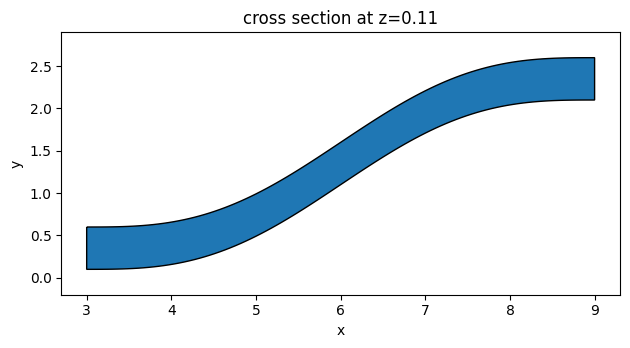

In [6]:
x_start = l_in + l_junction  # x coordinate of the starting point of the waveguide bends
x = np.linspace(
    x_start, x_start + l_bend, 100
)  # x coordinates of the top edge vertices
y = (
    (x - x_start) * h_bend / l_bend
    - h_bend * np.sin(2 * np.pi * (x - x_start) / l_bend) / (np.pi * 2)
    + w13 / 2
)  # y coordinates of the top edge vertices

# using concatenate to include bottom edge vertices
x = np.concatenate((x, np.flipud(x)))
y = np.concatenate((y, np.flipud(y - w1)))

# stacking x and y coordinates to form vertices pairs
vertices = np.transpose(np.vstack((x, y)))

wg_bend_1 = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t)), medium=si
)

# the second waveguide bend can be obtained simply by flipping the sign of the y coordinates of the first bend
vertices = np.transpose(np.vstack((x, -y)))

wg_bend_2 = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t)), medium=si
)

wg_bend_1.plot(z=t / 2)


Lastly, define the straight input and output waveguides using `Box`.

In [7]:
# straight input waveguide
wg_in = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -w1 / 2, 0), rmax=(l_in, w1 / 2, t)),
    medium=si,
)

# top straight output waveguide
wg_out_1 = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(l_in + l_junction + l_bend, w13 / 2 - w1 + h_bend, 0),
        rmax=(inf_eff, w13 / 2 + h_bend, t),
    ),
    medium=si,
)

# bottom straight output waveguide
wg_out_2 = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(l_in + l_junction + l_bend, -w13 / 2 - h_bend, 0),
        rmax=(inf_eff, -w13 / 2 + w1 - h_bend, t),
    ),
    medium=si,
)

# the entire model is the collection of all structures defined so far
y_junction = [wg_in, junction, wg_bend_1, wg_bend_2, wg_out_1, wg_out_2]


Define the simulation domain. Here we ensure sufficient buffer spacing in each direction. In general, we want to make sure that the structure is at least half a wavelength away from the domain boundaries unless it goes into the PML.

In [8]:
Lx = l_in + l_junction + l_out + l_bend  # simulation domain size in x direction
Ly = w13 + 2 * h_bend + 1.5 * lda0  # simulation domain size in y direction
Lz = 10 * t  # simulation domain size in z direction
sim_size = (Lx, Ly, Lz)


We will use a [ModeSource](../_autosummary/tidy3d.ModeSource.html?highlight=modesource) to excite the input waveguide using the fundamental TE mode. 

A [FluxMonitor](../_autosummary/tidy3d.FluxMonitor.html) is placed at the top output waveguide to measure the transmission. Similarly, A [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) is placed at the same location. Since we prefer not to excite higher order mode at the output waveguides, we need to perform mode decomposition to inspect the mode profile. Lastly, a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) is added to the xy plane to visualize the power flow.

In [9]:
# add a mode source as excitation
mode_source = td.ModeSource(
    center=(l_in / 2, 0, t / 2),
    size=(0, 4 * w1, 6 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    mode_index=0,
)

# add a flux monitor to measure transmission at the output waveguide
flux_monitor = td.FluxMonitor(
    center=(l_in + l_junction + l_bend + l_out / 2, w13 / 2 - w1 / 2 + h_bend, t / 2),
    size=(0, 4 * w1, 6 * t),
    freqs=freqs,
    name="flux",
)

# add a filed monitor to visualize field distribution at z=t/2
field_monitor = td.FieldMonitor(
    center=(0, 0, t / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# add a mode monitor to measure mode composition at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(l_in + l_junction + l_bend + l_out / 2, w13 / 2 - w1 / 2 + h_bend, t / 2),
    size=(0, 4 * w1, 6 * t),
    freqs=freqs,
    mode_spec=td.ModeSpec(num_modes=4, target_neff=n_si),
    name="mode",
)


Set up the simulation with the previously defined structures, source, and monitors. All boundaries are set to PML to mimic infinite open space. Since the top and bottom claddings are silicon oxide, we will set the medium of the background to silicon oxide. 

In principle, we can impose symmetry to reduce the computational load. Since this model is relatively small and quick to solve, we will simply model the whole device without using symmetry.

<AxesSubplot: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

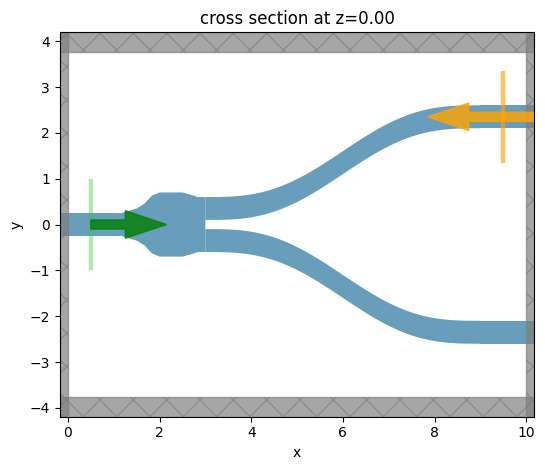

In [10]:
# construct simulation
sim = td.Simulation(
    center=(Lx / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=y_junction,
    sources=[mode_source],
    monitors=[flux_monitor, field_monitor, mode_monitor],
    run_time=5e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

sim.plot(z=0)


Before submitting the simulation to the server, it is a good practice to visualize the mode profile at the `ModeSource` to ensure we are launching the fundamental TE mode. To do so, we will use the [ModeSolver](../_autosummary/tidy3d.plugins.ModeSolver.html) plugin, which solves for the mode profile on your local computer.

In [11]:
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(l_in / 2, 0, t / 2), size=(0, 4 * w1, 6 * t)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()


/Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/twhughes/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Visualize the mode profile. We confirm that we are exciting the waveguide with the fundamental TE mode.

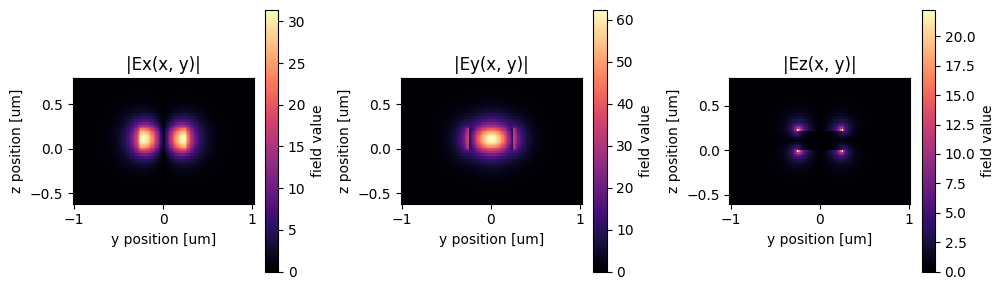

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="y", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="y", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="y", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, y)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, y)|")
ax3.set_aspect("equal")
plt.show()


Now that we verified all the settings, we are ready to submit the simulation job to the server.

In [13]:
job = web.Job(simulation=sim, task_name="y_junction")
sim_data = job.run(path="data/simulation_data.hdf5")


[22:09:17] INFO     Created task 'y_junction' with task_id '84aecb17-55cf-42b9-800c-e4b2955a99b8'.    ]8;id=332687;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=706591;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[22:09:20] INFO     Maximum FlexUnit cost: 0.172                                                      ]8;id=59450;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=616033;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                                                   ]8;id=902135;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=350207;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#262\262]8;;\

Output()

[22:09:27] INFO     status = preprocess                                                               ]8;id=109854;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=257901;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#274\274]8;;\

[22:09:31] INFO     starting up solver                                                                ]8;id=521083;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=483131;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#278\278]8;;\

[22:09:41] INFO     running solver                                                                    ]8;id=777085;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=10262;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#284\284]8;;\

Output()

[22:12:43] INFO     early shutoff detected, exiting.                                                  ]8;id=384724;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=642144;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                                              ]8;id=338940;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=115432;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#301\301]8;;\

Output()

[22:13:06] INFO     status = success                                                                  ]8;id=508137;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=706250;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#307\307]8;;\

           INFO     Billed FlexUnit cost: 0.083                                                       ]8;id=918832;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=250100;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#311\311]8;;\

[22:13:07] INFO     downloading file "output/monitor_data.hdf5" to "data/simulation_data.hdf5"        ]8;id=563636;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=199801;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#593\593]8;;\

Output()

[22:13:11] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=814437;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=138706;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#415\415]8;;\

## Result Visualization 

After the simulation is complete, we first inspect the insertion loss. Within this wavelength range, we see that the insertion loss is generally below 0.2 dB.

Text(0, 0.5, 'Insertion loss (dB)')

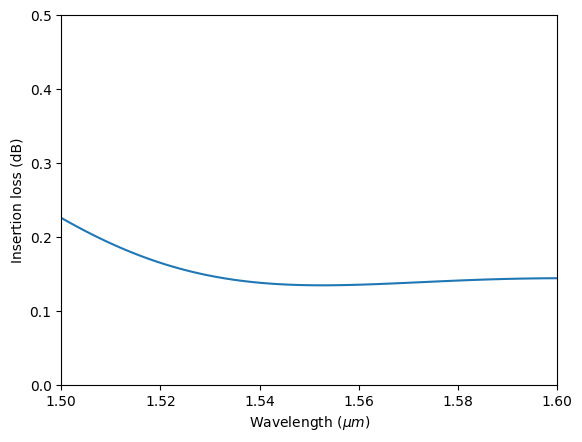

In [14]:
T = sim_data["flux"].flux  # transmission to the top waveguide
plt.plot(ldas, -10 * np.log10(2 * T))
plt.xlim(1.5, 1.6)
plt.ylim(0, 0.5)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Insertion loss (dB)")


We can also visualize the field distribution. Here we can see the interference in the junction while no visible higher order modes are excited at the output waveguides.

<AxesSubplot: title={'center': 'cross section at z=0.11'}, xlabel='x', ylabel='y'>

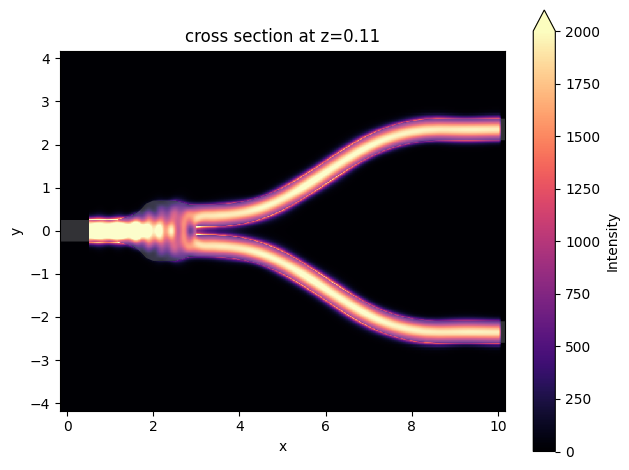

In [15]:
sim_data.plot_field("field", "int", f=freq0, vmin=0, vmax=2000)


To quantitatively determine the mode composition, we can extract the mode amplitudes at the output waveguide. The result clearly indicates that higher order modes are excited very little. The power is predominantly in the fundamental mode as desired.

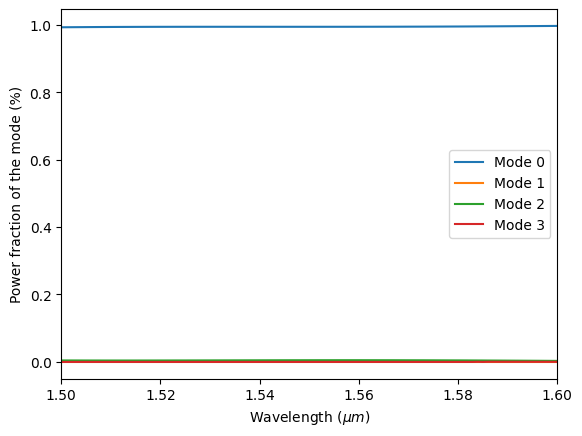

In [16]:
mode_amp = sim_data["mode"].amps.sel(direction="+")
mode_power = np.abs(mode_amp) ** 2 / T
plt.plot(ldas, mode_power)
plt.xlim(1.5, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Power fraction of the mode (%)")
plt.legend(["Mode 0", "Mode 1", "Mode 2", "Mode 3"])
